## QAOA on the same Max-Cut problem

QAOA (Quantum Approximate Optimization Algorithm) can be viewed as a special case of 
VQE (Variational Quantum Eigensolver).  

In QAOA, the ansatz takes the form of the Adiabatic Process operator with parameters $\beta$ and $\gamma$

$$
|\psi \rangle = e^{\beta_{n-1} H_M} e^{\gamma_{n-1} H_C} \dots e^{\beta_0 H_M} e^{\gamma_0 H_C} |+ \dots + \rangle
$$

Then, quantum computer and classical computer cooperating in a way that the quantum computer runs an estimator to calculate $\langle \psi | H_C | \psi \rangle$ while the classical computer runs an optimizer to find $\beta$ s and $\gamma$ s and feedback to quantum computer until ground state or highest energy state is found.

In [1]:
# setup

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
import qiskit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

# SciPy minimizer routine
from scipy.optimize import minimize

## Max-Cut example

5 nodes with node 0 connecting to every other nodes

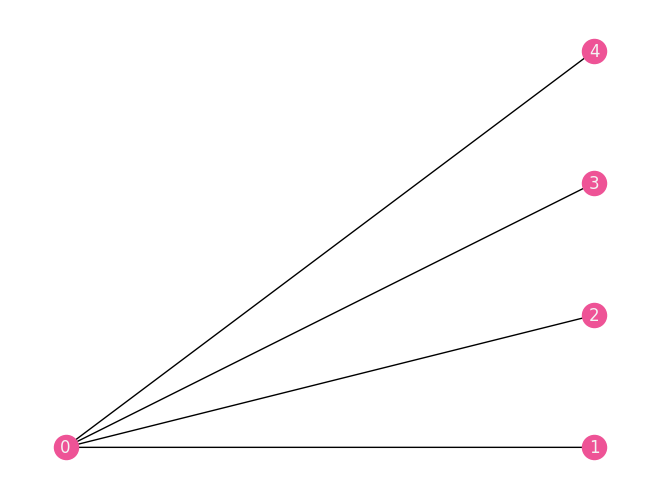

In [2]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

In [3]:
# use local simulator AerSimulator backend
# prepare the passmanager to transpile quantum circuit according to the backend

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend = AerSimulator()
backend.name
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Define Cost Hamiltonian $H_C$,

$$
H_C = - IIIZZ - IIZIZ - IZIIZ - ZIIIZ           
$$

QAOAAnsatz() takes the Mixer Hamiltonian $H_M$ as,

$$
H_M = XXXXX
$$

Define ansatz,

$$
|\psi \rangle = e^{\beta_{M-1} H_M} e^{\gamma_{M-1} H_C} \dots e^{\beta_0 H_M} e^{\gamma_0 H_C} |+ \dots + \rangle
$$

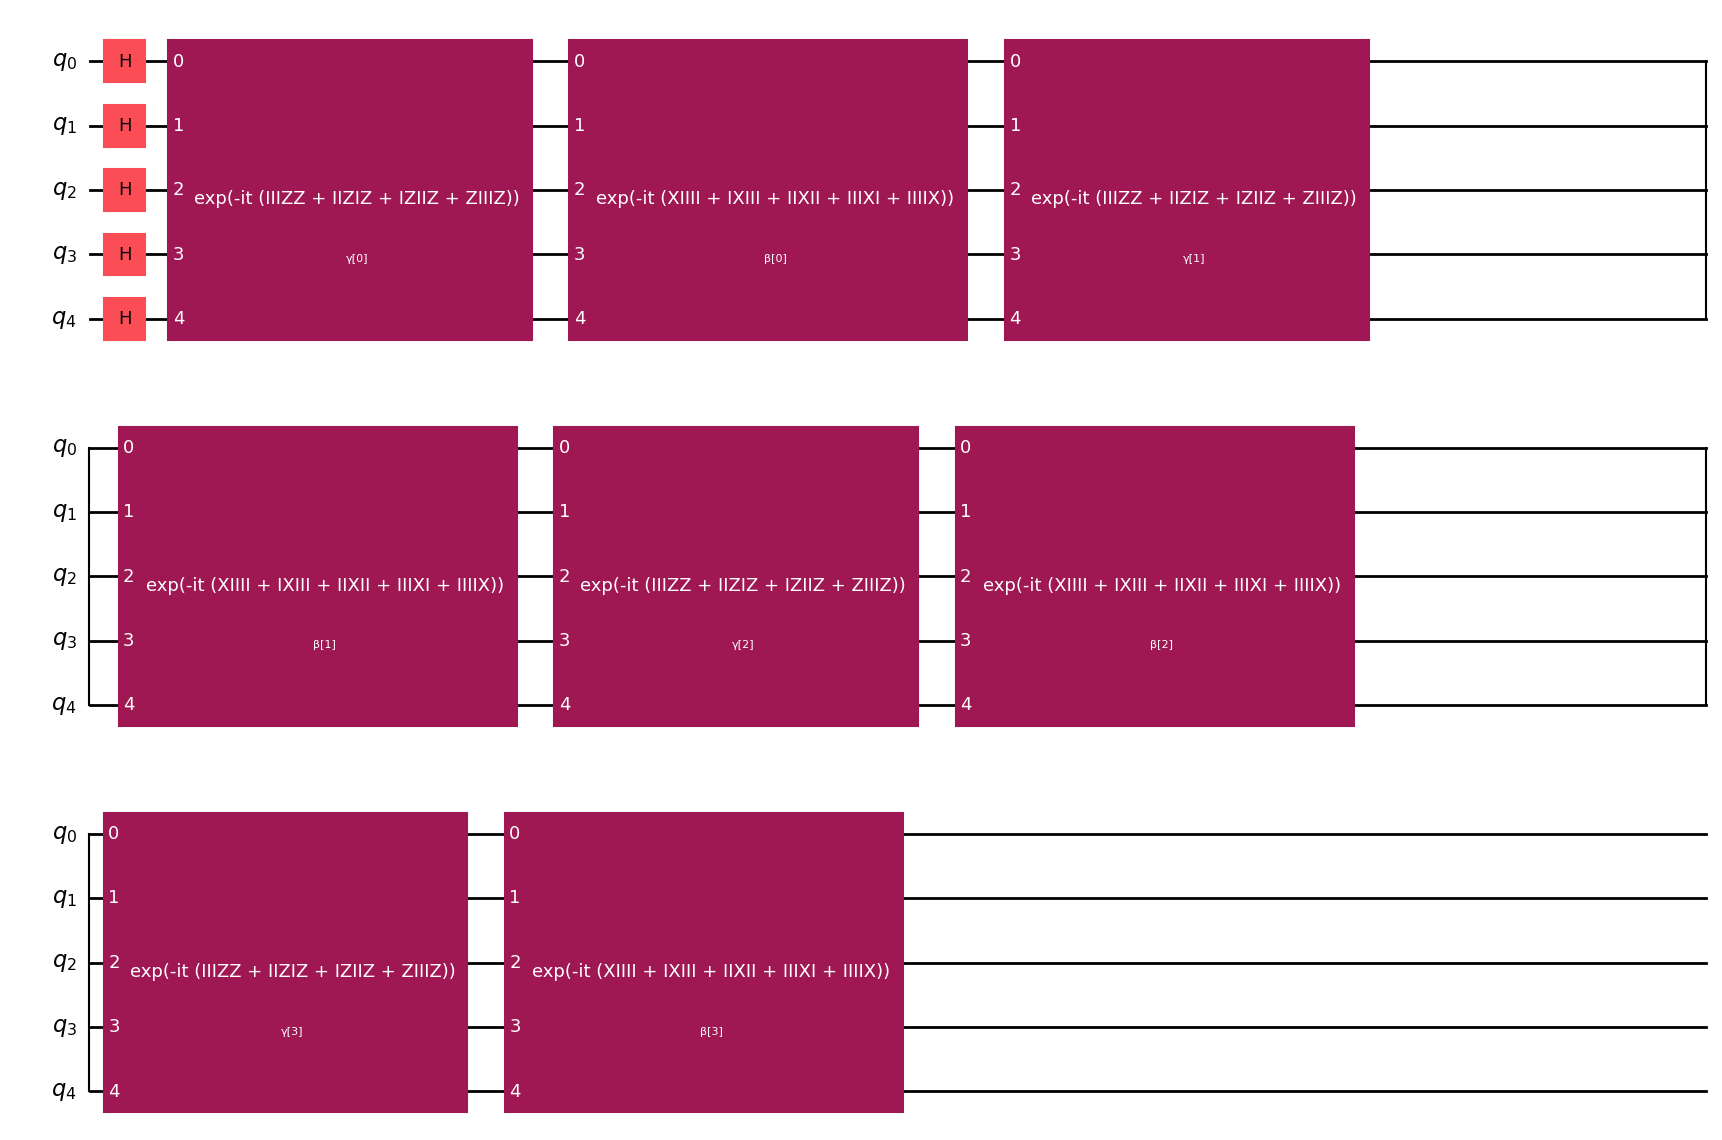

In [4]:
M = 4

# Problem to Hamiltonian operator
H_C = SparsePauliOp.from_list([("IIIZZ", -1), ("IIZIZ", -1), ("IZIIZ", -1), ("ZIIIZ", -1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(H_C, reps=M)

ansatz.decompose(reps=1).draw(output='mpl')

In [5]:
# transpile ansatz according to backend instruction set architecture (ISA)
# also apply to SparsePauliOp H_C

ansatz_isa = pm.run(ansatz)
H_C_isa = H_C.apply_layout(ansatz_isa.layout)
H_C_isa

SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])

Define cost_func1() for the optimizer.  It returns negative cost which works with scipy minimizer which is equivalent maximize the cost.

In [6]:
def cost_func1(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    qc = ansatz.assign_parameters(params)
    result = estimator.run(pubs=[(qc, hamiltonian)]).result()
    cost = result[0].data.evs
    return -cost        # minimize -cost == maximum cost

In [7]:
# define EstimatorV2 and SamplerV2

# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 10_000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 10_000
sampler.options.dynamical_decoupling.enable = True

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Ramdonly generate the initial $\beta$ s and $\gamma$ s.

In [8]:
import numpy as np
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

Apply minimize() to cost_func1()'s -cost.  Effectively, maximize the cost.

In [9]:
res = minimize(cost_func1, x0, args=(ansatz_isa, H_C_isa, estimator), method="COBYLA")

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 10000, 'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Found $\beta$ s and $\gamma$ s.  Their values may not correlate to the parameters in Adiabatic Process.

In [10]:
res.x

array([3.97232457, 1.03001621, 2.59433196, 1.27102432, 2.58342257,
       2.85465379, 4.34186519, 4.02923612])

Apply $\beta$ s and $\gamma$ s to the ansatz and plot the probability distribution of the measured qubits. 

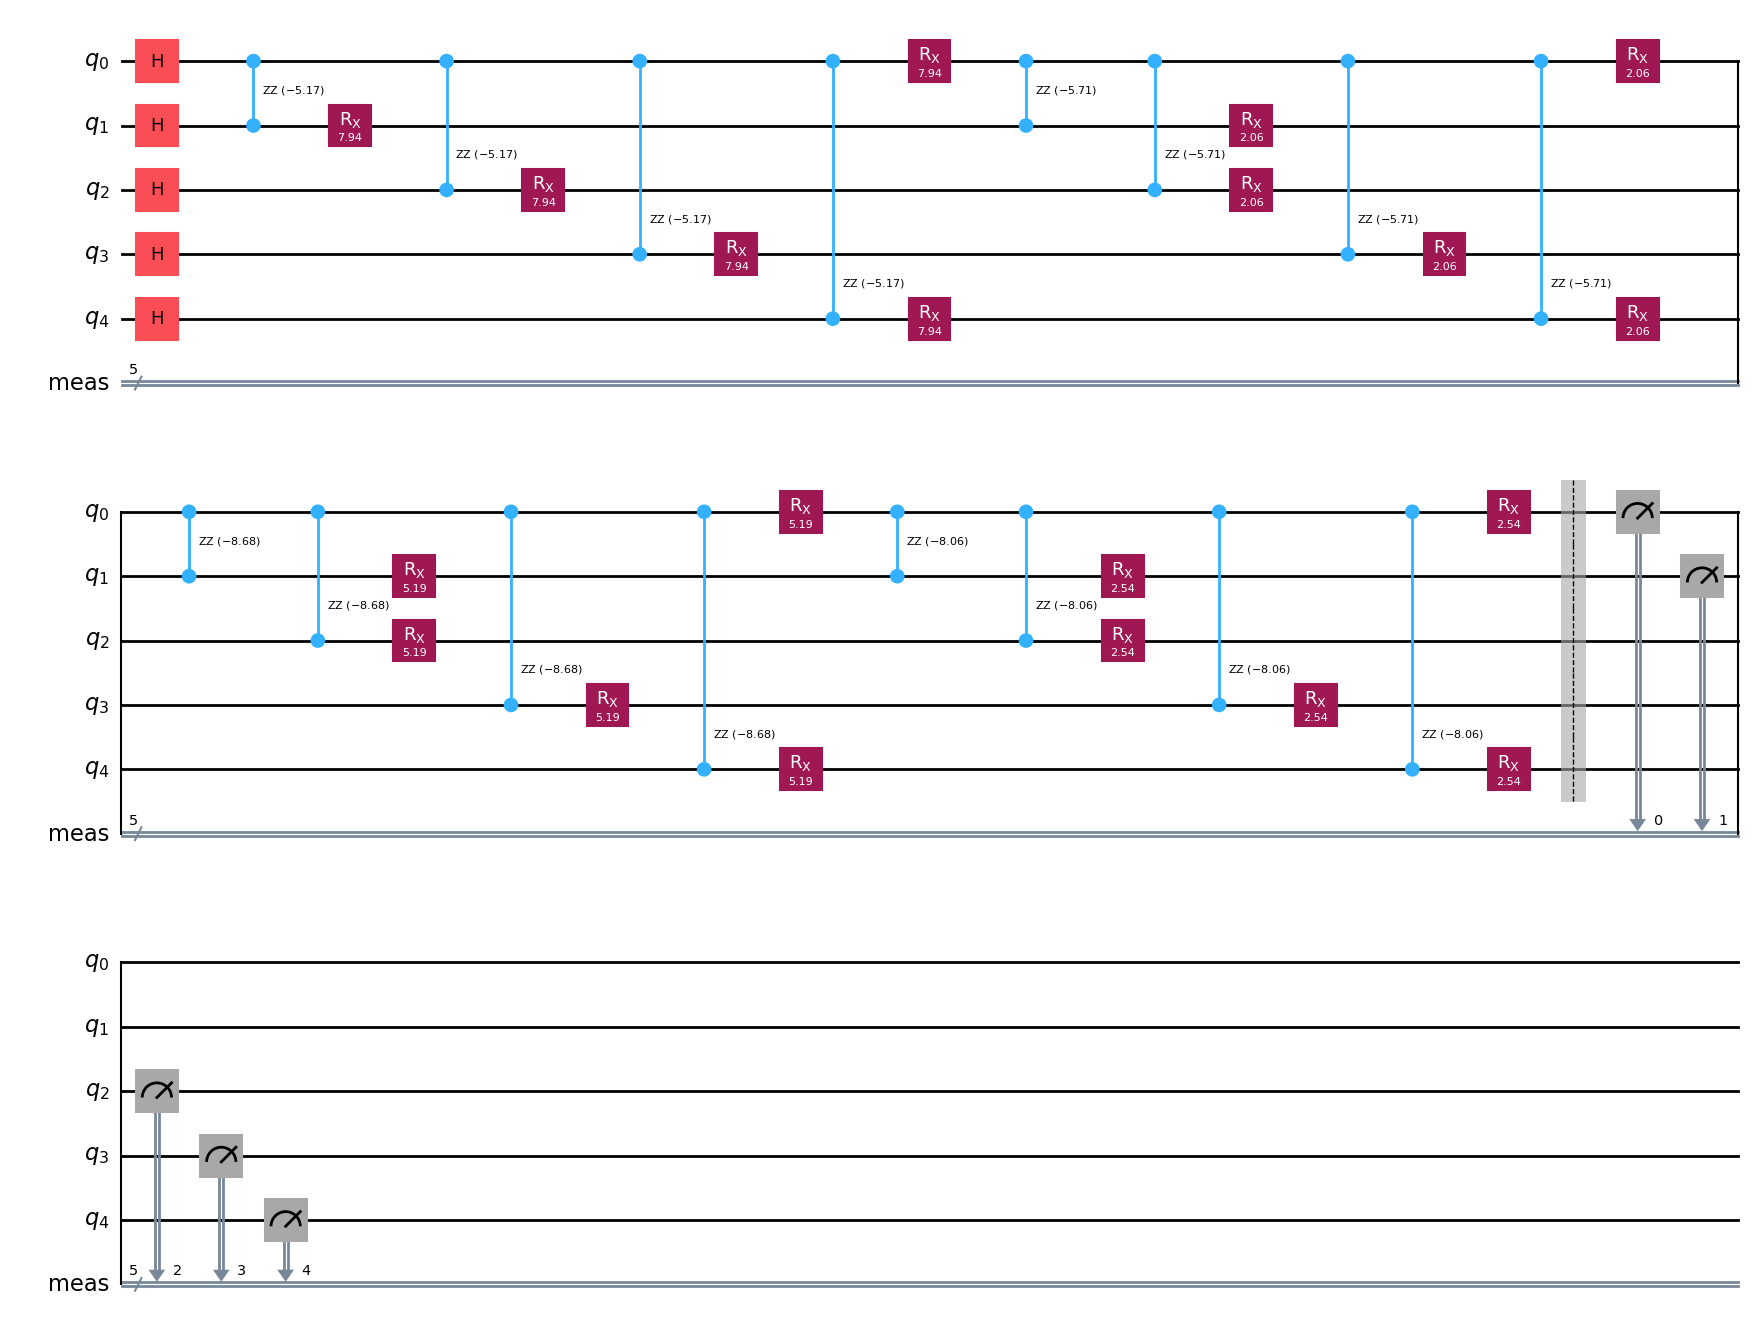

In [11]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl")

In [12]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

/Users/thyung/opt/anaconda3/envs/qiskit1_env/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


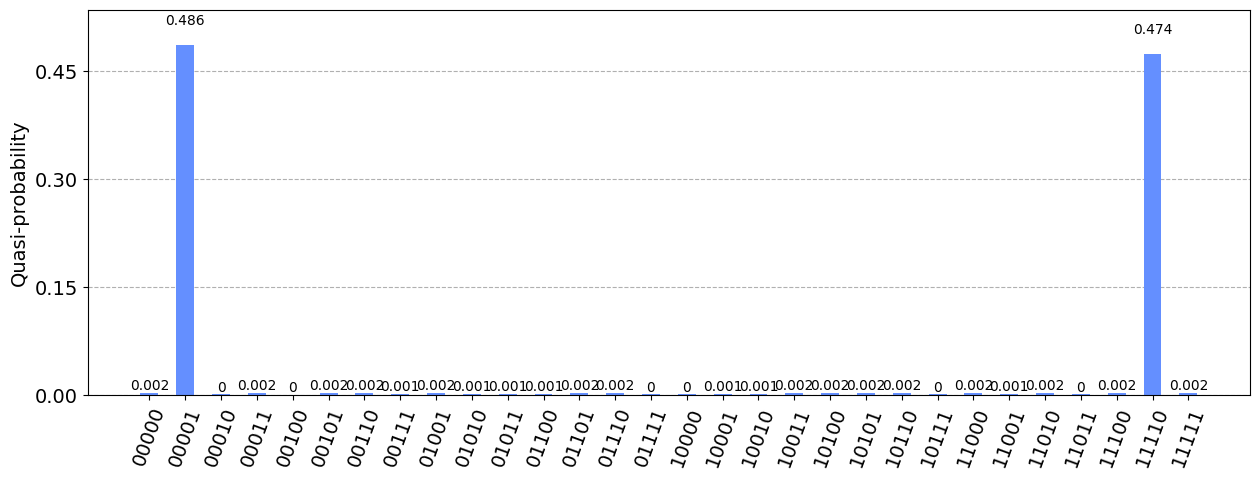

In [13]:
plot_distribution(samp_dist, figsize=(15, 5))

### Max-Cut solution using QAOA

Again, $|00001 \rangle$  and $|11110 \rangle$ show high probabilities.  This give same Max-Cut solution the sets {0} and {1, 2, 3, 4} as the Adabatic Process simulation.

### References:

1. Tutorial - Quantum approximate optimization algorithm, https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm
2. EstimatorV2 - https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2

In [14]:
qiskit.__version__

'1.0.2'